In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (12, 9)

## Sequential Labeling

A system that labels objects in binary images and compute their geometric properties.

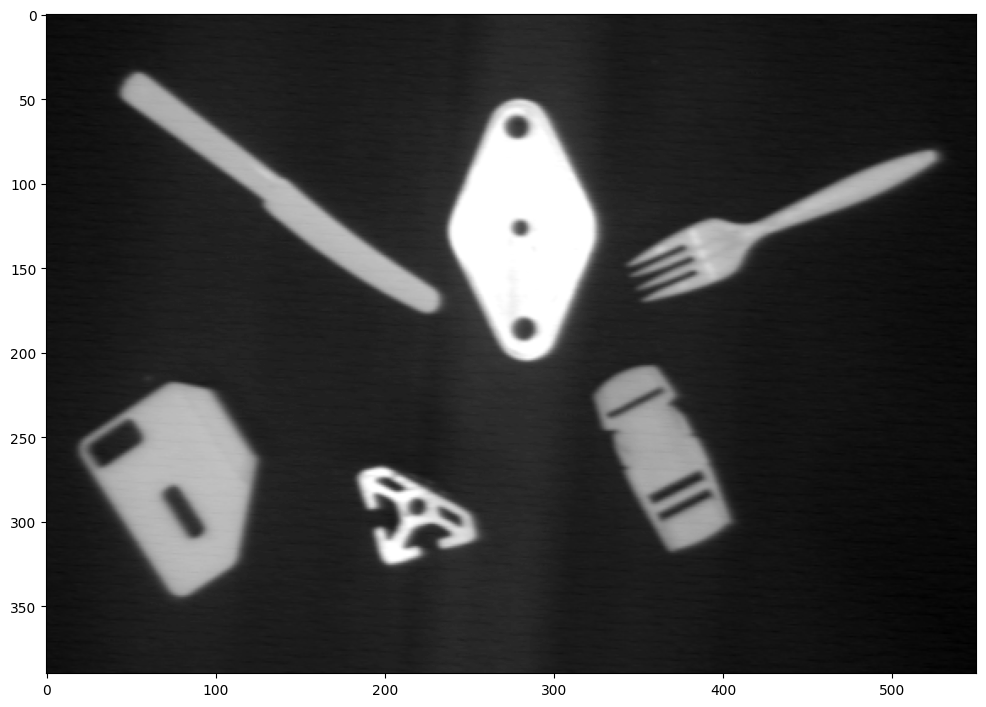

In [2]:
img = plt.imread('data/many_objects_2.png')

plt.imshow(img, cmap='gray')
plt.show()

### Image Binarization

The following function converts a grayscale image to a binary one by thresholding the pixel intensities. Each element in the output array must be a Boolean value where `True` indicates that the intensity of the corresponding pixel in the input is greater than or equal to the threshold value.

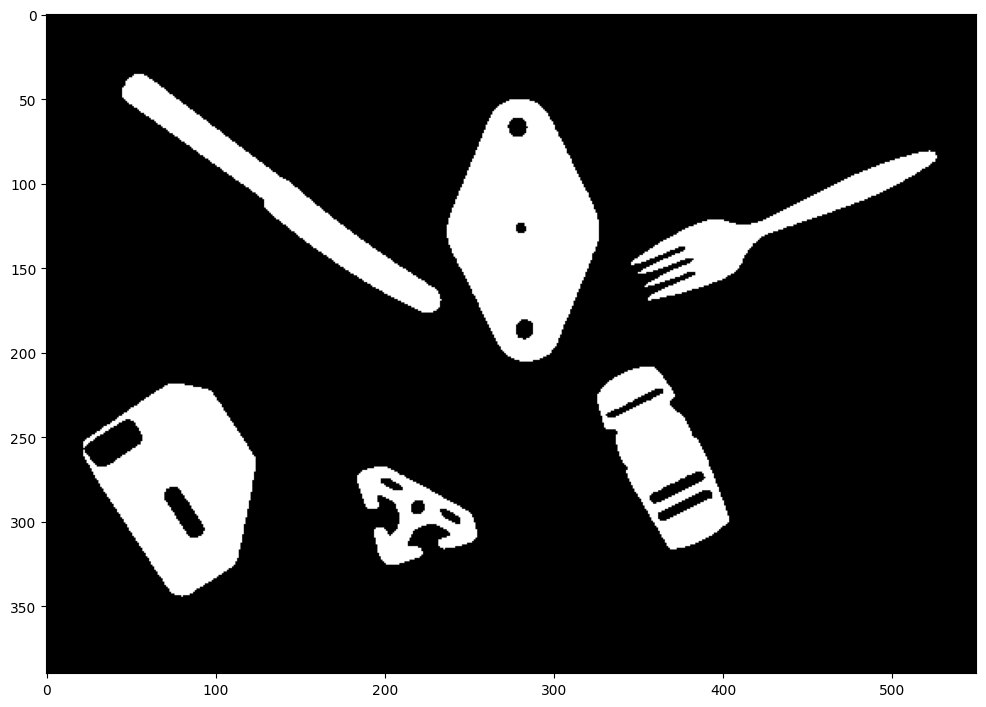

In [3]:
def binarize(gray_img, thresh_val):
    """Converts a grayscale image to a binary image by thresholding.
    
    Args:
    - gray_img: H x W array representing a grayscale image.
    - thresh_val: Threshold value.
    
    Returns:
    - binary_img: H x W Boolean array representing the thresholded image.
    """
    binary_img = gray_img >= thresh_val
    return binary_img

binary_img = binarize(img, thresh_val=0.5)

plt.imshow(binary_img, cmap='gray')
plt.show()

### Label Connected Regions

I implement the sequential labeling algorithm in the following function. The function takes a binary image as input and returns an array of the same size. The output array should have data type `int`, where each element is an object label. For example, all background pixels have value 0, all pixels of object 1 has value 1, etc.

In the first pass, pixels are assigned labels based on the labels of their neighbors. This labeling process may result in the same area having multiple labels, which is resolved in the second pass.

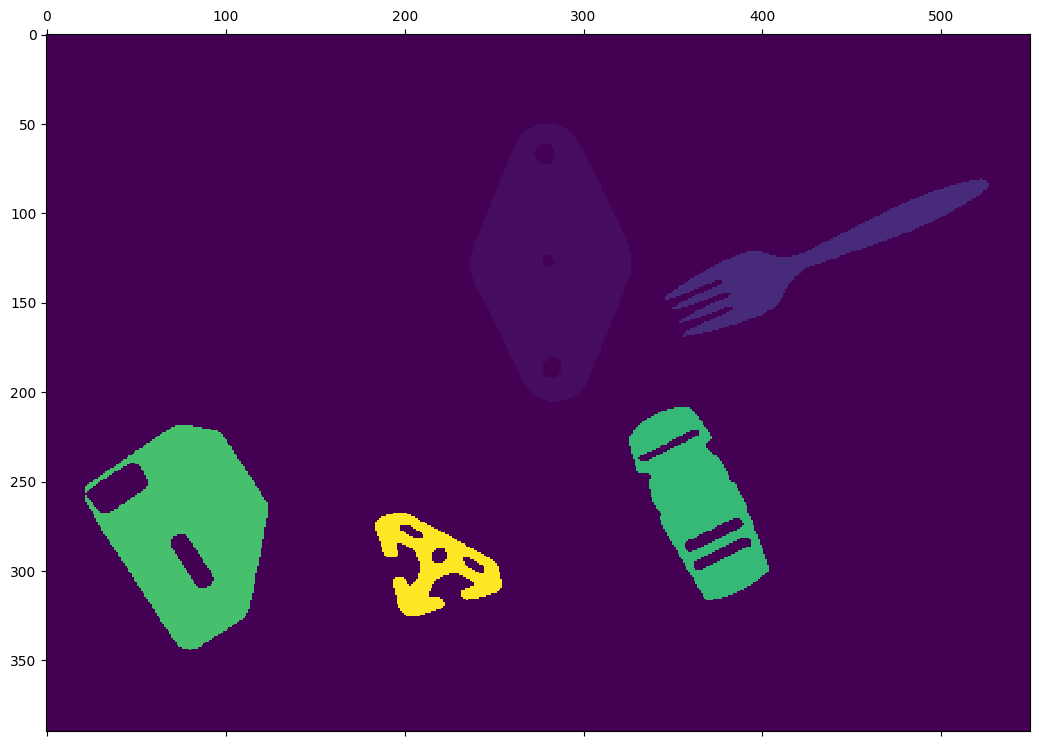

Found 6 objects in image.


In [4]:
def label(binary_img):
    """Label disconnected regions in a binary image.
    
    Args:
    - binary_img: H x W Boolean array representing a binary image where `False`
        indicates background while `True` indicates object regions.
    
    Returns:
    - label_img: H x W int array representing an image with labeled object
        regions where 0 indicates the background while other values represent
        object labels.
    """

    rows = len(binary_img)
    cols = len(binary_img[0])
    label_img = np.zeros_like(binary_img, dtype=int)
    label = 1
    equivalences = {}
    # first pass, label all pixels based on sequential labeling rules
    for i in range(rows):
        for j in range(cols):
            # check if the pixel is not part of the background
            if binary_img[i, j] == True:
                # b is the cell above, c is the cell to the left, and d is the cell to the top-left
                b = label_img[i - 1, j] if 0 <= i - 1 < rows else 0
                c = label_img[i, j - 1] if 0 <= j - 1 < cols else 0
                d = label_img[i - 1, j - 1] if 0 <= i - 1 < rows and 0 <= j - 1 < cols else 0
                if b == 0 and c == 0 and d == 0:
                    # the pixel gets a new label
                    label_img[i, j] = label
                    label += 1
                elif d != 0:
                    # follow rules for sequential labeling
                    label_img[i, j] = d
                elif b == 0 and c != 0:
                    # follow rules for sequential labeling
                    label_img[i, j] = c
                elif b != 0 and c == 0:
                    # follow rules for sequential labeling
                    label_img[i, j] = b
                elif b == c:
                    # b and c are equal, so no conflict
                    label_img[i, j] = b
                else:
                    # b and c are not equal, add to equivalences
                    label_img[i, j] = b
                    if b in equivalences:
                        equivalences[c] = equivalences[b]
                    else:
                        equivalences[c] = b
    # second pass, resolve equivalences
    for i in range(rows):
        for j in range(cols):
            # trace to original equivalence value
            while label_img[i, j] in equivalences:
                label_img[i, j] = equivalences[label_img[i, j]]
                
    return label_img

label_img = label(binary_img)
plt.matshow(label_img)
plt.show()

obj_count = len(np.unique(label_img)) - 1
print(f"Found {obj_count} objects in image.")

Below I implemented object detection using DFS. The asymptotic runtime is the same as the Sequential Labeling Algorithm and the implementation is more intuitive. The resulting labels are also more predictable as there is no need to resolve equivalent labels. However, the Sequential Labeling Algorithm is a little bit more efficient as it only needs to check three neighbors for each pixel whereas the DFS algorithm would need to check eight neighbors.

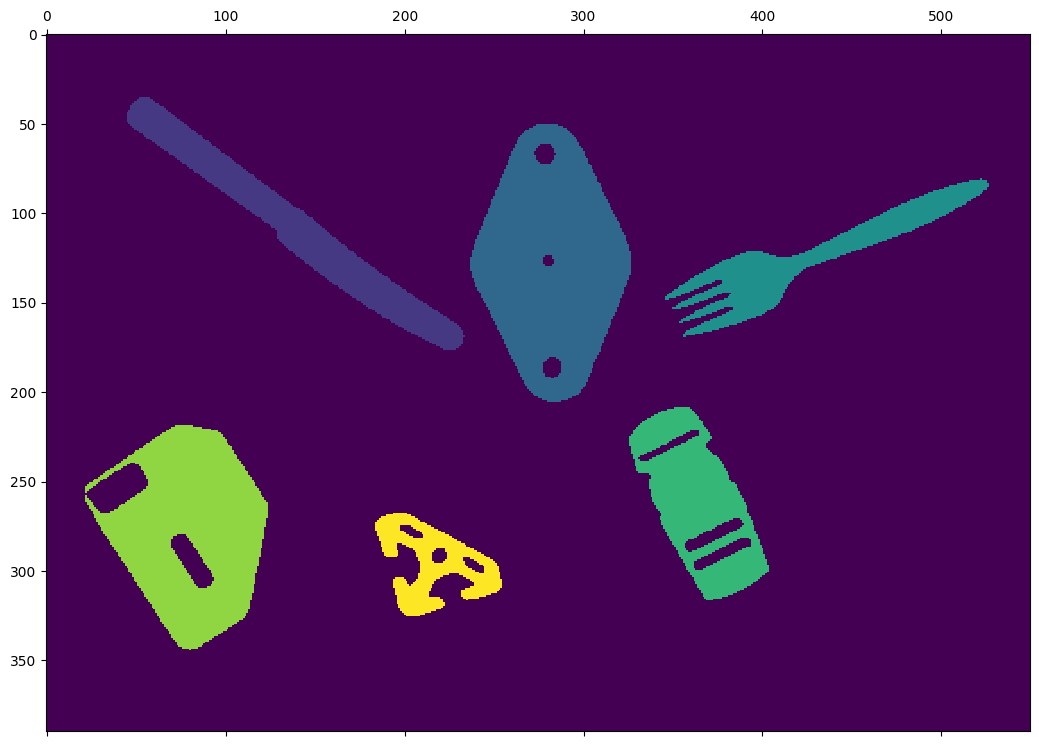

Found 6 objects in image.


In [5]:
def label(binary_img):
    """Label disconnected regions in a binary image.
    
    Args:
    - binary_img: H x W Boolean array representing a binary image where `False`
        indicates background while `True` indicates object regions.
    
    Returns:
    - label_img: H x W int array representing an image with labeled object
        regions where 0 indicates the background while other values represent
        object labels.
    """
    
    rows = len(binary_img)
    cols = len(binary_img[0])
    label_img = np.zeros_like(binary_img, dtype=int)
    label = 1
    for i in range(rows):
        for j in range(cols):
            if binary_img[i][j] == True and label_img[i][j] == 0:
                dfs(binary_img, label_img, i, j, label)
                label += 1
                
    return label_img

def dfs(binary_img, label_img, i, j, label):
    stack = [(i, j)]
    while stack:
        i, j = stack.pop()
        if i >= 0 and j >= 0 and i < len(binary_img) and j < len(binary_img[0]) and binary_img[i][j] == True and label_img[i][j] == 0:
            label_img[i][j] = label
            stack.extend([(i - 1, j - 1), (i - 1, j), (i - 1, j + 1), (i, j - 1), (i, j + 1), (i + 1, j - 1), (i + 1, j), (i + 1, j + 1)])

label_img = label(binary_img)
plt.matshow(label_img)
plt.show()

obj_count = len(np.unique(label_img)) - 1
print(f"Found {obj_count} objects in image.")

### Calculate Geometric Attributes

In the cell below, calculate the geometric attributes (center, orientation, second moment) of each object. A code snippet has been provided to visualize these attributes. To be specific, for each object, we mark the center of the object, and draws an ellipse having the same orientation and second moments around the center.

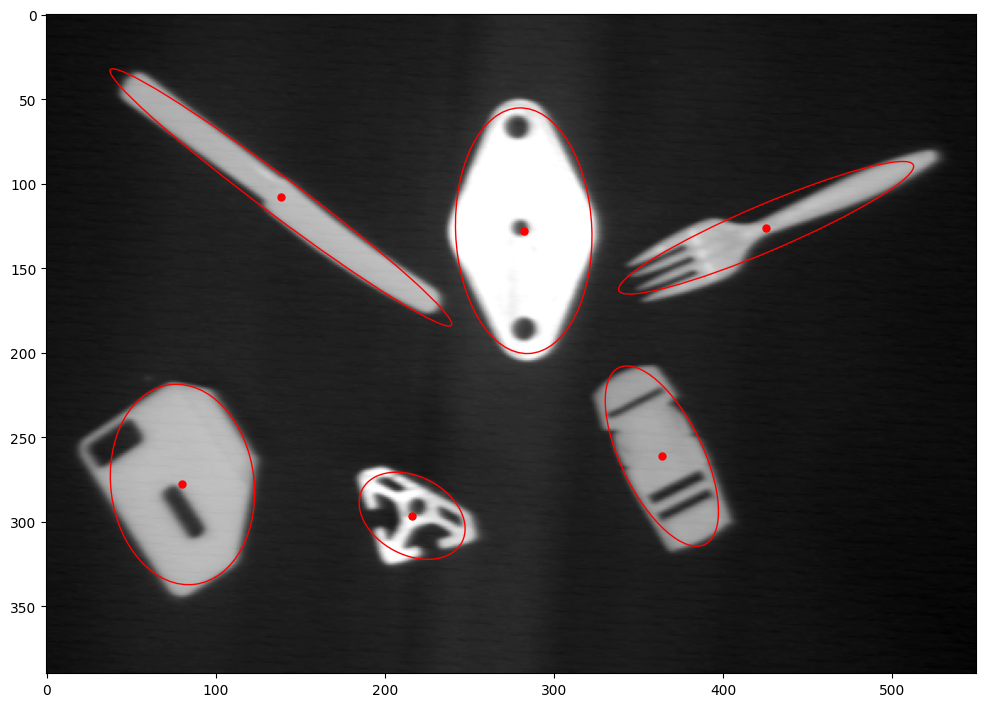

In [6]:
from matplotlib.patches import Ellipse


def calculate_geometric_attributes(label_img, label):
    """Find the geometric attributes of an object in a labeled image.
    
    The origin of the coordinate system is at the top left corner of the image.
    The x axis points to the right. The y axis points down.
    
    Args:
    - label_img: H x W int array representing an image with labeled object
        regions where 0 indicates the background while other values represent
        object labels.
    - label: Label of the object for which we want to calculate the geometric
        attributes.
        
    Returns:
    - cx, cy: xy coordinates of the object center.
    - theta: Orientation of the object in radians.
    - emin, emax: Second moments of the object.
    """

    rows = len(label_img)
    cols = len(label_img[0])
    area = 0
    cx = cy = 0
    # compute x and y values for the center of the circle
    for y in range(rows):
        for x in range(cols):
            if label_img[y][x] == label:
                area += 1
                cx += x
                cy += y
    cx /= area
    cy /= area
    # compute a, b, and c values using cx amd cy
    a = b = c = 0
    for y in range(rows):
        for x in range(cols):
            if label_img[y][x] == label:
                a += (x - cx) ** 2
                b += 2 * (x - cx) * (y - cy)
                c += (y - cy) ** 2
    # calculate theta1 and theta2
    theta1 = np.arctan2(b, a - c) / 2
    theta2 = theta1 + (np.pi / 2)
    theta = theta1
    # calculate emin and emax
    emin = a * np.sin(theta1) ** 2 - b * np.sin(theta1) * np.cos(theta1) + c * np.cos(theta1) ** 2
    emax = a * np.sin(theta2) ** 2 - b * np.sin(theta2) * np.cos(theta2) + c * np.cos(theta2) ** 2
    
    return cx, cy, theta, emin, emax

    
plt.imshow(img, cmap='gray')
labels = [l for l in np.unique(label_img) if l]
for label in labels:
    cx, cy, t, e1, e2 = calculate_geometric_attributes(label_img, label)
    
    # Visualization.
    # Plot the center of the area.
    plt.plot(cx, cy, marker='o', markersize=5, color=(1,0,0))
    # Plot an ellipse having the same orientation and second moments as the area.
    ew = 2 * ((4/np.pi)**(1/4)) * (e1**(-1/8)) * (e2**(3/8))
    eh = ew * np.sqrt(e1 / e2)
    plt.gca().add_patch(Ellipse((cx, cy), ew, eh, t*180/np.pi,
        facecolor='none', edgecolor=(1,0,0), linewidth=1))
plt.show()

## Hough Transform

In this example I implemented the Hough transform to find coins in the sample image below.

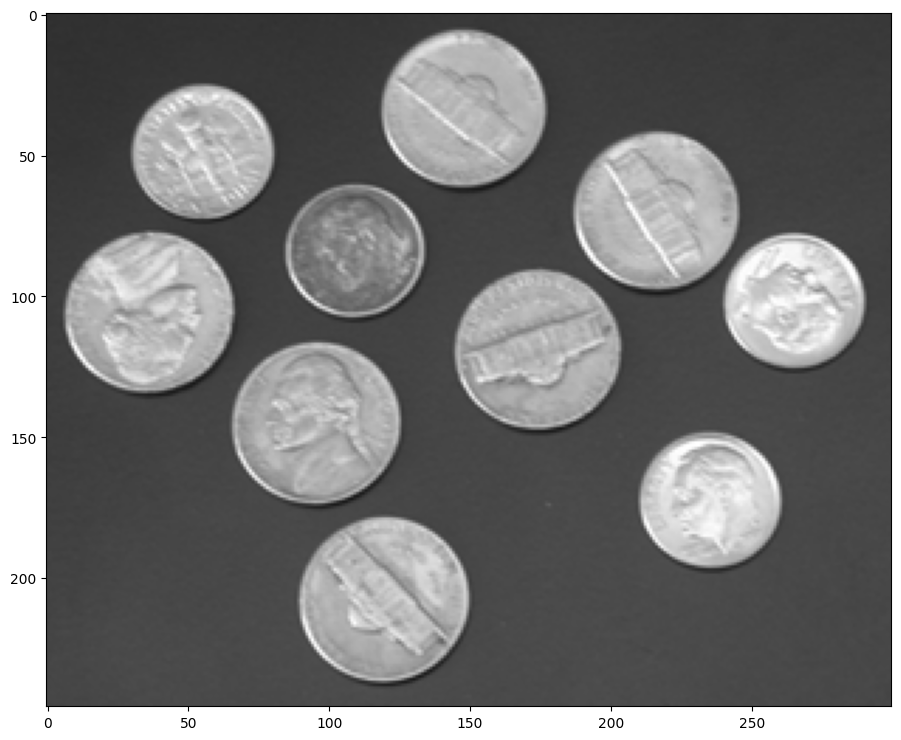

In [7]:
img = cv2.imread('data/coins.png')
plt.imshow(img, cmap='gray')
plt.show()

### Edge Detection

Detect edges in the sample image.

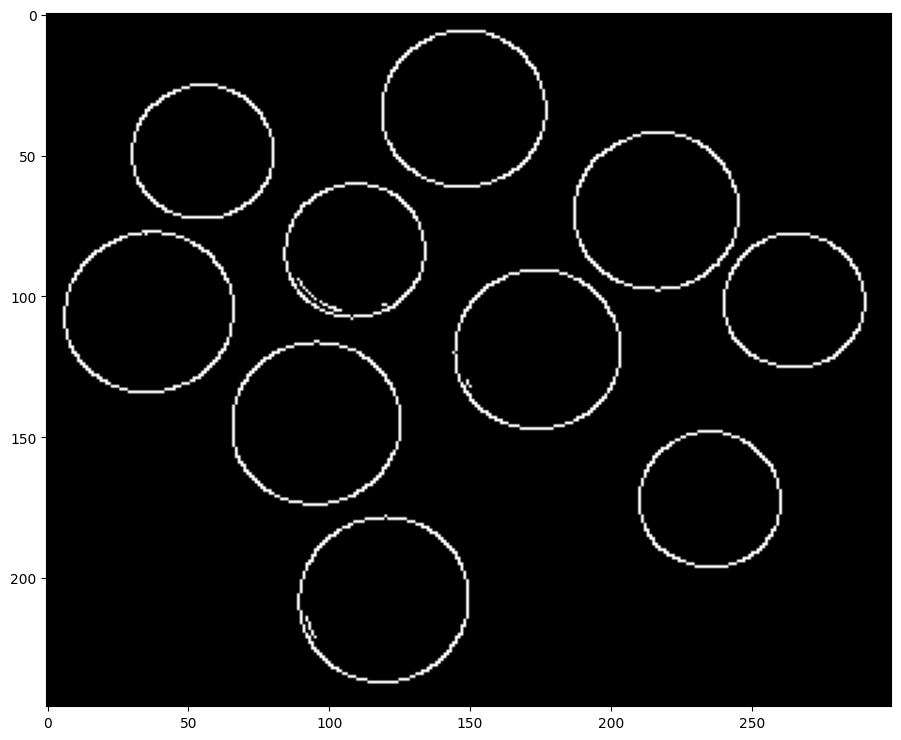

In [8]:
edge_img = cv2.Canny(img, 300, 600)
plt.imshow(edge_img, cmap='gray')
plt.show()

### Hough Transform

The following function detects circles using the Hough transform. The function should return the accumulator array instead of a list of circles.

In [9]:
def hough_circles(edge_img, radii):
    """Find circles in an image containing edge pixels.
    
    Args:
    - edge_img: H x W uint8 edge image where 0 indictes non-edge pixels
        whereas 255 indicates edge pixels.
    - radii: A list of R radius values. Only circles whose radius is in this
        list will be found.
    
    Returns:
    - score_map: R x W x H accumulator array. `score_map[r_idx, y, x]`
        represents the total votes received by the circle of radius
        radii[r_idx] centered at pixel `edge_img[y, x]`.
    """

    rows = len(edge_img)
    cols = len(edge_img[0])
    radiiLength = len(radii)
    # accumulator array
    score_map = np.zeros((radiiLength, rows, cols))
    # iterate through edge_img
    for y in range(rows):
        for x in range(cols):
            # it is an edge if the value of edge_img[y, x] is 255
            if edge_img[y, x] == 255:
                # compute values for a and b such that (x - a)^2 + (y - b)^2 = r^2 where r = radius
                for i in range(360):
                    theta = i / (2 * np.pi)
                    # iterate through radii
                    for r in range(radiiLength):
                        radius = int(radii[r])
                        # compute new point (a, b) using (x, y), different angles theta, and radius
                        b = y + int(radius * np.sin(theta))
                        a = x + int(radius * np.cos(theta))
                        if 0 <= b < rows and 0 <= a < cols:
                            # for new points, increment score in accumulator array by 1
                            score_map[r, b, a] += 1

    return score_map

radii = np.arange(25., 31.)
score_map = hough_circles(edge_img, radii)

Visualize the score map (accumulator array) corresponding to `radii[0]`.

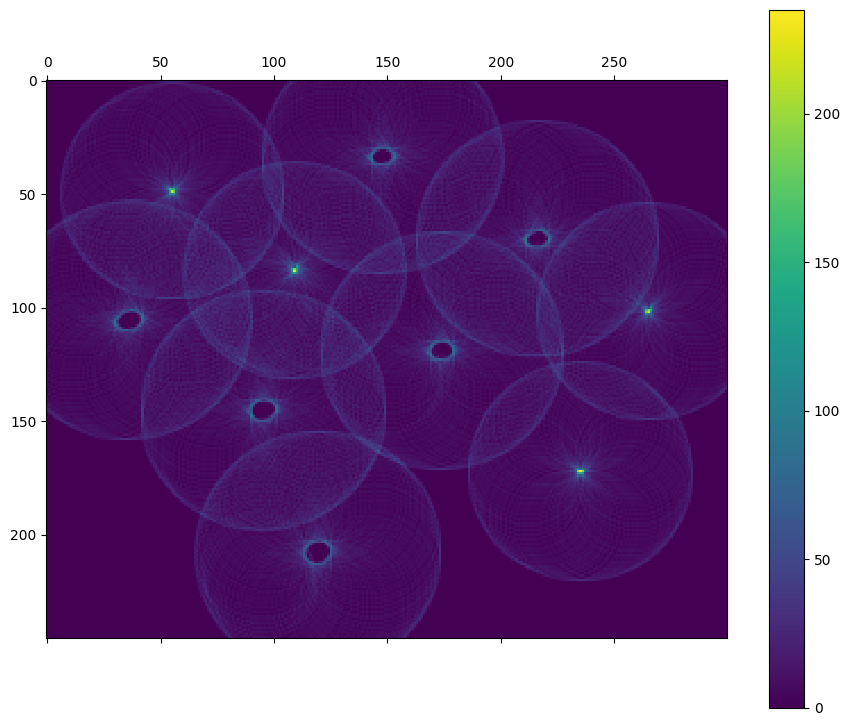

In [10]:
plt.matshow(score_map[0])
plt.colorbar()
plt.show()

From the accumulator array, pick the top scoring circles and display them. It is fine (and expected) if you detect multiple circles for a single coin. We will address this in the next section.

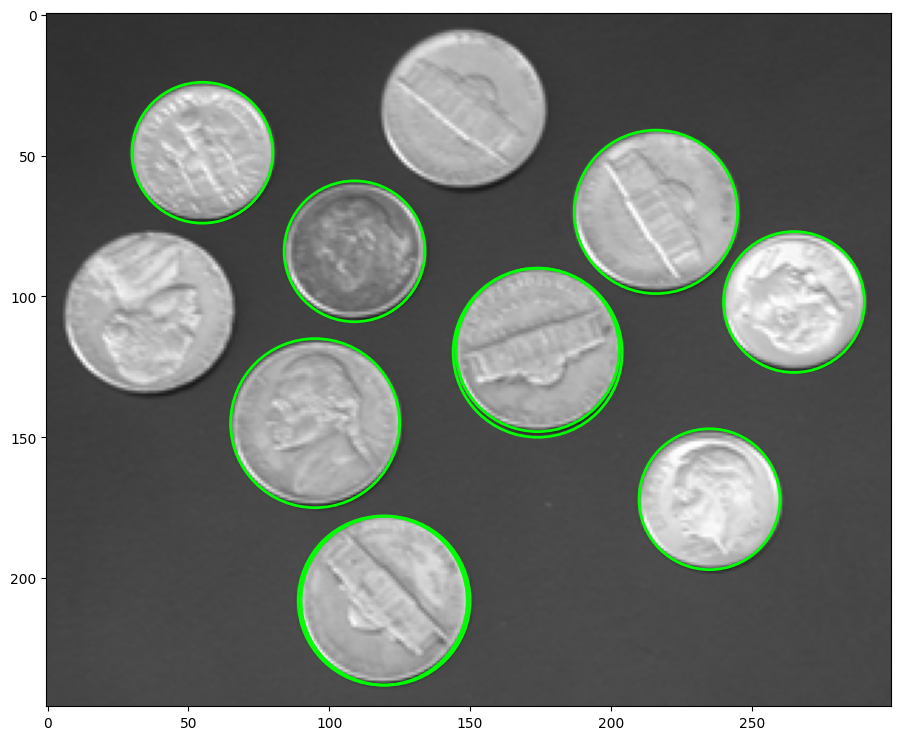

In [11]:
from matplotlib.patches import Circle

plt.imshow(img, cmap='gray')
ris, ys, xs = np.unravel_index(np.argsort(score_map.ravel())[-10:], score_map.shape)
for ri, y, x in zip(ris, ys, xs):
    r = radii[ri]
    plt.gca().add_patch(Circle((x, y), r, facecolor='none', edgecolor=(0,1,0), linewidth=2))
plt.show()

### Non-Maximum Suppression

You may have observed that your results in the last section contain duplicate detections if you want to detect all coins. This is quite common in detection systems including the neural network detectors that we will cover in the second half of this course. A post-processing step called non-maximum suppression is often needed to remove these duplicate detections. In our case, if two circles overlap with each other too much, we can assume they are duplicate detections and discard the one with lower votes. For the entire list of detections, we could sort them based on votes and repeat this process to suppress duplicate detections.

The final results should contain all coins without duplicates.

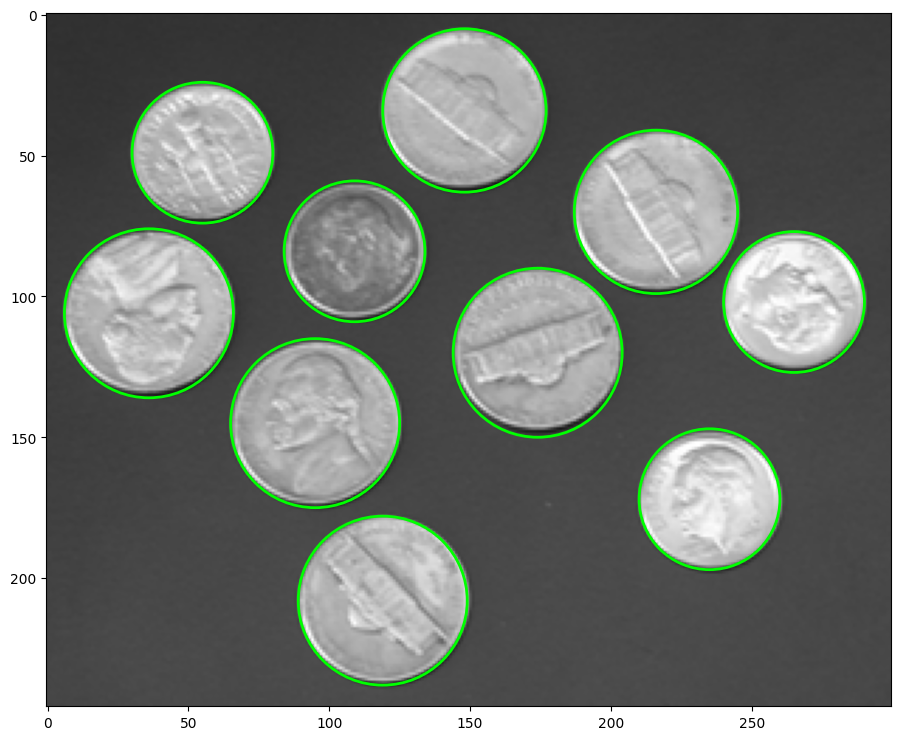

In [12]:
import copy

def non_maximum_suppression(score_map, radii):
    # create deepcopy of score_map
    score_map_copy = copy.deepcopy(score_map)
    rows = len(score_map_copy[0])
    cols = len(score_map_copy[0, 0])
    radiiLength = len(radii)
    # start with current max score in score_map
    count = -1
    maxR, maxY, maxX = np.unravel_index(np.argsort(score_map_copy.ravel())[count], score_map_copy.shape)
    # continue while-loop when current max score is not 0
    while score_map_copy[maxR, maxY, maxX] != 0:
        maxRadius = radii[maxR]
        # iterate through all scores in score_map
        for r in range(radiiLength):
            radius = radii[r]
            for y in range(rows):
                for x in range(cols):
                    # compute distance between current max score point and current point
                    distance = np.sqrt((maxX - x) ** 2 + (maxY - y) ** 2)
                    # set current point score to 0 if not current max score point and distance less than max radius and radius (circles overlap)
                    if (radius != maxRadius or y != maxY or x != maxX) and distance <= maxRadius + radius:
                        score_map_copy[r, y, x] = 0
        # next iteration using next max score not overlapping with previous max scores
        count -= 1
        maxR, maxY, maxX = np.unravel_index(np.argsort(score_map_copy.ravel())[count], score_map_copy.shape)
        
    return score_map_copy

suppressed_score_map = non_maximum_suppression(score_map, radii)

plt.imshow(img, cmap='gray')
ris, ys, xs = np.unravel_index(np.argsort(suppressed_score_map.ravel())[-10:], suppressed_score_map.shape)
for ri, y, x in zip(ris, ys, xs):
    r = radii[ri]
    plt.gca().add_patch(Circle((x, y), r, facecolor='none', edgecolor=(0,1,0), linewidth=2))
plt.show()